<a href="https://colab.research.google.com/github/MuayThaiLegz/TutoringLessons/blob/main/Lab10_Support_vector_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CMPS 320
## Lab 10: Support Vector Machines


# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In this Lab we will be using the iris dataset. This is a famous dataset that contains the sepal and petal length and width (all in cm) of 150 iris flowers of three different species: Iris setosa, Iris versicolor, and Iris virginica.

# Linear SVM classification

The following Scikit-Learn code loads the iris dataset, scales the features, and then trains a linear SVM model (using the LinearSVC class with a regularization parameter, C=1) to detect Iris virginica flowers.

If your SVM model is overfitting, you can try regularizing it by reducing C.

[SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [22]:
import pandas as pd
import numpy as np

def p2f(x):
    return float(x.strip('%')) / 100 if isinstance(x, str) else x

data = pd.read_csv( "Analytics.csv",skiprows=11)

df = data.iloc[:1265]

df.columns = ["Keyword","Bounce_Rate", 'Goals']
df['Bounce_Rate'] = df['Bounce_Rate'].apply(p2f)


In [31]:
df['Keyword'] = df['Keyword'].str.lower()

<ipython-input-31-e2d3f0821869>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Keyword'] = df['Keyword'].str.lower()


In [71]:
df

,Keyword,Bounce_Rate,Goals
0,biomedical waste disposal,0.7490,84
1,biohazardous waste disposal,0.7865,81
2,sharps disposal,0.8604,81
3,medical waste company,0.7657,80
4,sharps waste,0.8450,75
...,...,...,...
1260,where can i dispose of used sharp container in...,1.0000,0
1261,where can i get rid of sharps- nh,1.0000,0
1262,where can people get rid of their sharps conta...,1.0000,0
1263,where can sharps containers be disposed of all...,1.0000,0


In [40]:
sharps = pd.DataFrame()
wheredf = pd.DataFrame()


for i, word in enumerate(df['Keyword']):
    if 'where' in word:
        wheredf[f'{word}'] = df.iloc[i]

    elif 'sharps' in word:
      sharps[f'{word}'] = df.iloc[i]


<ipython-input-40-9e8065a1623d>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sharps[f'{word}'] = df.iloc[i]
<ipython-input-40-9e8065a1623d>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sharps[f'{word}'] = df.iloc[i]
<ipython-input-40-9e8065a1623d>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

In [52]:
wheredf.reset_index(drop=True, inplace=True)
sharps.reset_index(drop=True, inplace=True)
sharpsdf = sharps.iloc[1:]
for i in sharpsdf.columns:
  sharpsdf[i] = sharpsdf[i].astype(float)
sharpsdf.iloc[:, :4].plot(kind='bar')

In [56]:
for i in sharpsdf.columns:
  sharpsdf[i] = sharpsdf[i].astype(float)
sharpsdf.iloc[:, :4].plot(kind='bar')

<ipython-input-56-50c0f9d2f93a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sharpsdf[i] = sharpsdf[i].astype(float)


In [72]:
sharpsdf

,sharps disposal,sharps waste,sharps disposal services,sharps needles disposal,+sharps +disposal,sharps bins,sharps waste removal,sharps waste disposal,sharps medical waste disposal,sharps disposal az,...,sharps waste services,south carolina sharps hospita,state of georgia regulations for disposal of sharps,stericycle sharps disposal,tn sharps disposal,vicksburg michigan sharps drop box,warren county nj sharps disposal,waste management sharps eu claire,westchester county sharps disposal,what to do with used sharps in pa
1,0.8604,0.845,0.845,0.8553,0.8173,0.8542,0.8246,0.7581,0.8521,0.75,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,81.0000,75.000,44.000,43.0000,41.0000,37.0000,10.0000,19.0000,25.0000,20.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: title={'center': 'Sharp Values'}>

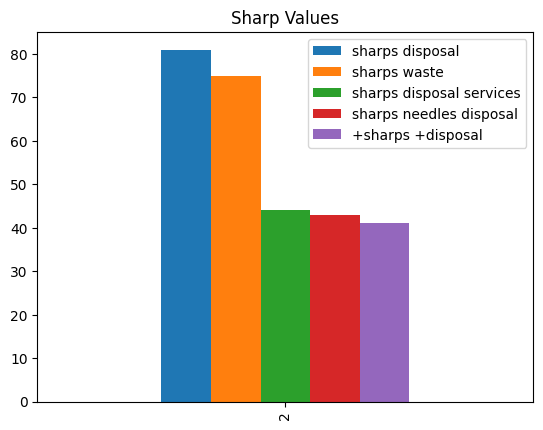

In [70]:
sharpsdf.iloc[1:, :5].plot(kind='bar', title='Sharp Values')

In [33]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

import pandas as pd

# Define a function to convert percentage strings to floats
def p2f(x):
    return float(x.strip('%')) / 100 if isinstance(x, str) else x

# Read the CSV file, skipping rows until the actual data headers
# Specify the `converters` parameter to handle percentage columns
cols = ['Keyword,Bounce Rate,Pages / Session,Goal Completions,Clicks,Time after Search']

data = pd.read_csv(
    "/content/AnalyticsMainAdvoSiteGoogleAdsKeywords.csv",
    skiprows=11,  # Adjust this number based on where your actual data headers start
    converters={'Bounce Rate': p2f},
    names=cols
)

# Replace '#NAME?' with NaN (or any other placeholder you deem appropriate)
data.replace('#NAME?', pd.NA, inplace=True)

# Convert 'Day Index' to datetime if it's not already parsed correctly
if 'Day Index' in data.columns:
    data['Day Index'] = pd.to_datetime(data['Day Index'], errors='coerce')

# Display the first few rows to verify
data.iloc[0]



Keyword,Bounce Rate,Pages / Session,Goal Completions,Clicks,Time after Search    00:00:00
Name: (+medical +waste +pick +up, 100.00%, 1.0, 0, 8), dtype: object

In [25]:

# iris = datasets.load_iris()
# X = iris["data"][:, (2, 3)]  # petal length, petal width
# y = (iris["target"] == 2).astype(np.float64)  # Iris virginica
import pandas as pd
cols = ['Keyword,Bounce Rate,Pages / Session,Goal Completions,Clicks,Time after Search']
data = pd.read_csv("/content/AnalyticsMainAdvoSiteGoogleAdsKeywords.csv", delimiter=';', skiprows=4, names = cols)

In [26]:
data

,"Keyword,Bounce Rate,Pages / Session,Goal Completions,Clicks,Time after Search"
0,# ----------------------------------------
1,"Keyword,Bounce Rate,Pages / Session,Goal Compl..."
2,"+Bio +Waste +pick +up,100.00%,1.00,0,6,00:00:00"
3,"+bio medical +waste,100.00%,1.00,0,28,00:00:00"
4,"+medical +disposal,100.00%,1.00,0,171,00:00:00"
...,...
1352,"10/1/23,74.29%"
1353,"10/2/23,72.55%"
1354,"10/3/23,62.50%"
1355,"10/4/23,56.10%"


In [3]:
iris["data"][:, (2, 3)]

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.7, 0.4],
       [1.4, 0.3],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.5, 0.1],
       [1.5, 0.2],
       [1.6, 0.2],
       [1.4, 0.1],
       [1.1, 0.1],
       [1.2, 0.2],
       [1.5, 0.4],
       [1.3, 0.4],
       [1.4, 0.3],
       [1.7, 0.3],
       [1.5, 0.3],
       [1.7, 0.2],
       [1.5, 0.4],
       [1. , 0.2],
       [1.7, 0.5],
       [1.9, 0.2],
       [1.6, 0.2],
       [1.6, 0.4],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.6, 0.2],
       [1.6, 0.2],
       [1.5, 0.4],
       [1.5, 0.1],
       [1.4, 0.2],
       [1.5, 0.2],
       [1.2, 0.2],
       [1.3, 0.2],
       [1.4, 0.1],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.3, 0.3],
       [1.3, 0.3],
       [1.3, 0.2],
       [1.6, 0.6],
       [1.9, 0.4],
       [1.4, 0.3],
       [1.6, 0.2],
       [1.4, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [4.7, 1.4],
       [4.5, 1.5],
       [4.9,

In [4]:
(iris["target"] == 2).astype(np.float64)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [5]:

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, random_state=42)),
    ])

svm_clf.fit(X, y)

ParserError: ignored

We make predictions as follows:

In [ ]:
svm_clf.predict([[5, 1.7]])

### Remarks:

Unlike Logistic Regression classifiers, SVM classifiers do not output probabilities for each class.

Instead of using the LinearSVC class, we could use the SVC class with a linear kernel.

When creating the SVC model, we would write SVC(kernel="linear", C=1).

We could also use the SGDClassifier class, with SGDClassifier(loss="hinge", alpha=$1/(m*C$))-- This applies regular Stochastic Gradient Descent to train a linear SVM classifier.

It does not converge as fast as the LinearSVC class, but it can be useful to handle  huge datasets that do not fit in memory.

# Non-linear SVM classification

We will test the non-linear svm on the moons dataset: this is a toy dataset for binary classification in which the data points are shaped as two interleaving half circles.

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

One approach to handling nonlinear datasets is to add more features, such as polynomial features.

To implement this idea using Scikit-Learn, we create a Pipeline containing a PolynomialFeatures transformer followed by a StandardScaler and a LinearSVC.

### Linear SVM classifier using polynomial features|

In [ ]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

In [ ]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

### Polynomial Kernel

This code trains an SVM classifier using a third-degree polynomial kernel on the moons dataset:

In [ ]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

The hyperparameter **coef0** controls how much the model is influenced by high degree
polynomials versus low-degree polynomials.

This code trains an SVM classifier using a tenth-degree polynomial kernel.

In [ ]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

#### Remarks

If your model is overfitting, you might want to reduce the polynomial degree. Conversely, if it is underfitting, you can try increasing it.

The hyperparameter coef0 controls how much the model is influenced by high degree polynomials versus low-degree polynomials.

A common approach to finding the right hyperparameter values is
to use grid search. It is often faster to first do a very
coarse grid search, then a finer grid search around the best values
found.

### Gaussian RBF Kernel

Just like the polynomial features method, the similarity features method can be useful with any Machine Learning algorithm, but it may be computationally expensive to compute all the additional features, especially on large training sets. To overcome this issue we use the Gaussian RBF kernel:

In [ ]:
## SVM classifiers using an RBF kernel

rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

In [ ]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

The plots show models trained with different values of hyperparameters gamma (γ) and C.

Increasing gamma (γ) makes the bell-shaped curve narrower. As a result, each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small gamma (γ) value makes the bell-shaped curve wider: instances have a larger range of influence, and the decision boundary ends up smoother.

Gamma (γ) acts like a regularization hyperparameter: if your model is overfitting, you should reduce it; if it is underfitting, you should increase it.